In [63]:
# NIVELL 1 - EXERCICI 1:
# Connecta Python amb MySQL Workbench i carrega les dades de la teva base de dades del Sprint 4 per utilitzar-les en tots els exercicis.

import pymysql
import pandas as pd
conexión = pymysql.connect(host= "127.0.0.1", user= "root", passwd= "Pedito-1520", database= "sprint4_bis")

try:
    cursor = conexión.cursor()

    # Obtenim la llista de taules
    cursor.execute("SHOW TABLES")
    taules = [fila[0] for fila in cursor.fetchall()]

    # Diccionari per guardar les dades de cada taula com a DataFrame
    dades = {}
    for taula in taules:
        df = pd.read_sql(f"SELECT * FROM `{taula}`", conexión)
        dades[taula] = df
        print(f"Taula '{taula}' carregada amb {len(df)} files.")

finally:
    conexión.close()

C:\Users\joanr\AppData\Local\Temp\ipykernel_9868\1246375766.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM `{taula}`", conexión)


Taula 'companies' carregada amb 100 files.
Taula 'credit_cards' carregada amb 5000 files.
Taula 'estado_tarjetas' carregada amb 5000 files.
Taula 'products' carregada amb 100 files.
Taula 'transaction_product' carregada amb 253391 files.
Taula 'transactions' carregada amb 100000 files.
Taula 'users_all' carregada amb 5000 files.


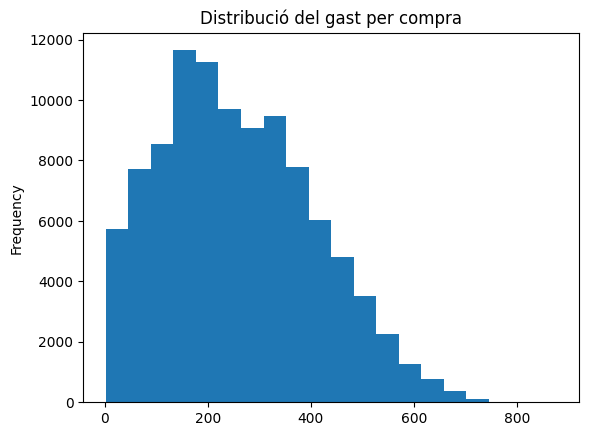

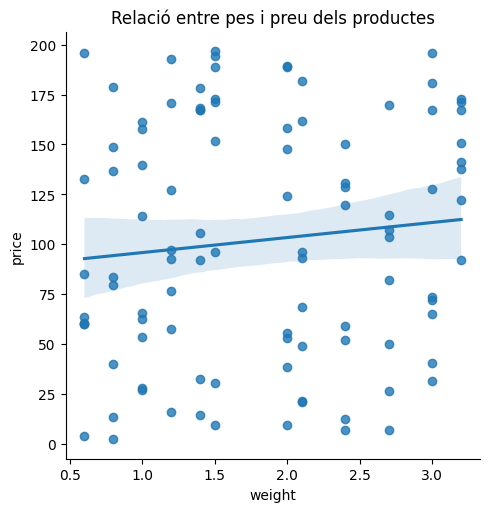

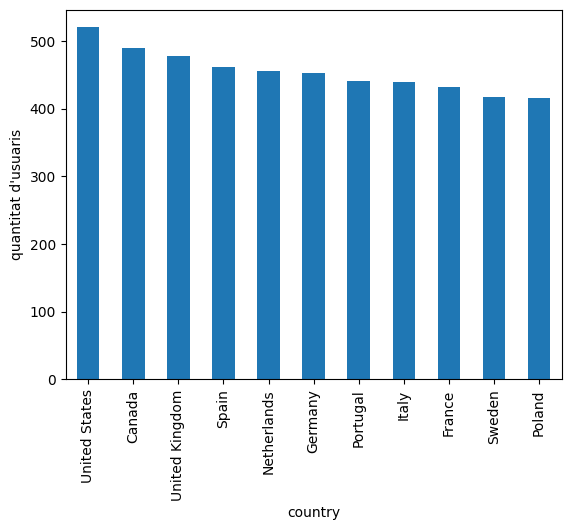

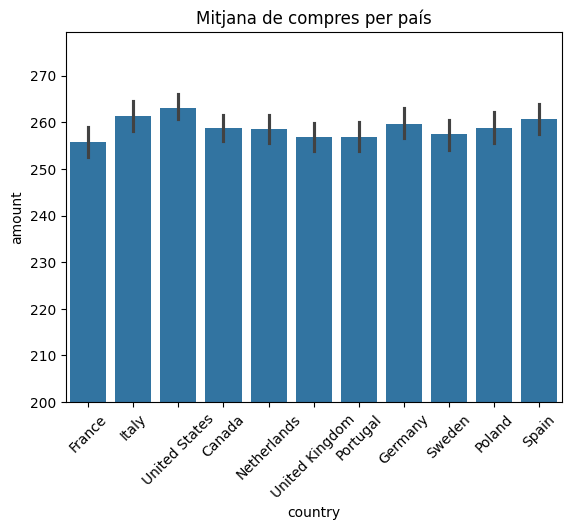

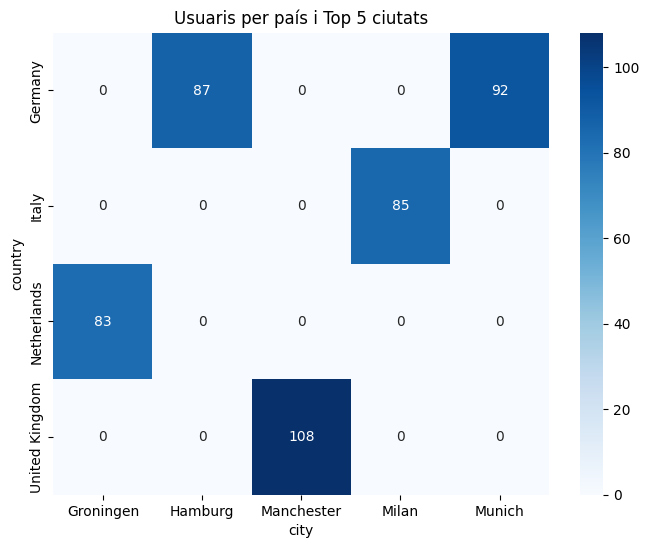

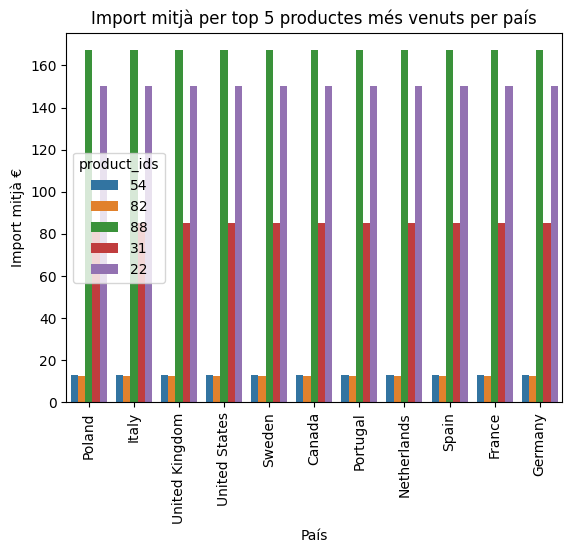

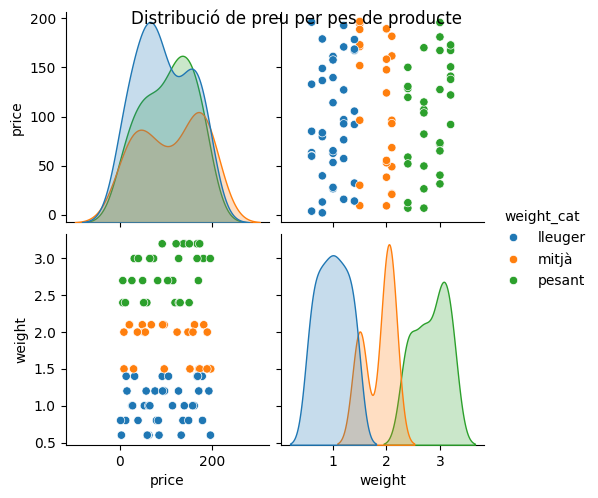

In [64]:
# EXERCICI 2:  Per a cada ítem, crea una visualització adequada segons les variables especificades. 
# Interpreta els resultats segons les teves dades.

import matplotlib.pyplot as plt 
import seaborn as sns

# Una variable numèrica.
df_transactions = dades["transactions"]
df_transactions["amount"].plot.hist(bins = 20)
plt.title("Distribució del gast per compra")


# Dues variables numèriques.
df_products = dades["products"].copy()

    # Eliminar el símbol $ i convertir a numèric
df_products["price"] = df_products["price"].str.replace("$", "", regex=False)
df_products["price"] = pd.to_numeric(df_products["price"])

    # fem el gràfic
sns.lmplot(data= df_products, x= "weight", y= "price")
plt.title("Relació entre pes i preu dels productes")
plt.show()

# Una variable categòrica
df_users_all = dades["users_all"]
df_users_all["country"].value_counts().plot.bar()
plt.ylabel("quantitat d'usuaris")
plt.show()

# Una variable numèrica i una categòrica
merged = df_transactions.merge(df_users_all, left_on="user_id", right_on="id")
sns.barplot(data=merged, x="country", y="amount", estimator="mean")
plt.xticks(rotation=45)
plt.title("Mitjana de compres per país")
plt.ylim(200, None)
plt.show()

# Dues variables categòriques.

top_cities = df_users_all["city"].value_counts().head(5).index
df_users_all["city"] = df_users_all["city"].where(df_users_all["city"].isin(top_cities))

ct = pd.crosstab(df_users_all["country"], df_users_all["city"])
plt.figure(figsize=(8,6))
sns.heatmap(ct, cmap="Blues", annot=True, fmt="d")
plt.title("Usuaris per país i Top 5 ciutats")
plt.show()


# Tres variables combinades.
top_products = merged["product_ids"].value_counts().head(5).index
df_top = merged[merged["product_ids"].isin(top_products)]

sns.barplot(data=df_top, x="country", y= "amount", hue="product_ids", estimator= "mean")
plt.title("Import mitjà per top 5 productes més venuts per país")
plt.ylabel("Import mitjà €")
plt.xlabel("País")
plt.xticks(rotation=90)
plt.show()

# Crea un Pairplot.

df_products["weight_cat"] = pd.cut(df_products["weight"], bins=3, labels=["lleuger","mitjà","pesant"])

sns.pairplot(df_products, vars=["price","weight"], hue="weight_cat")
plt.suptitle("Distribució de preu per pes de producte")
plt.show()


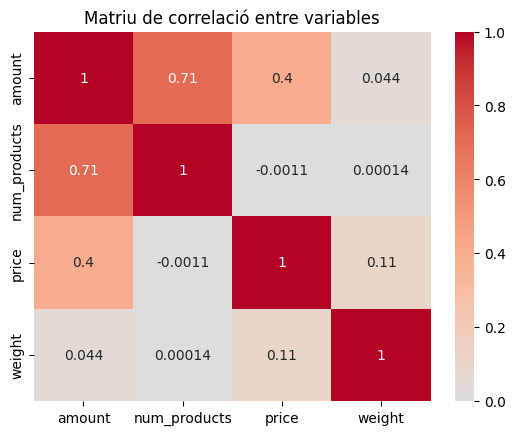

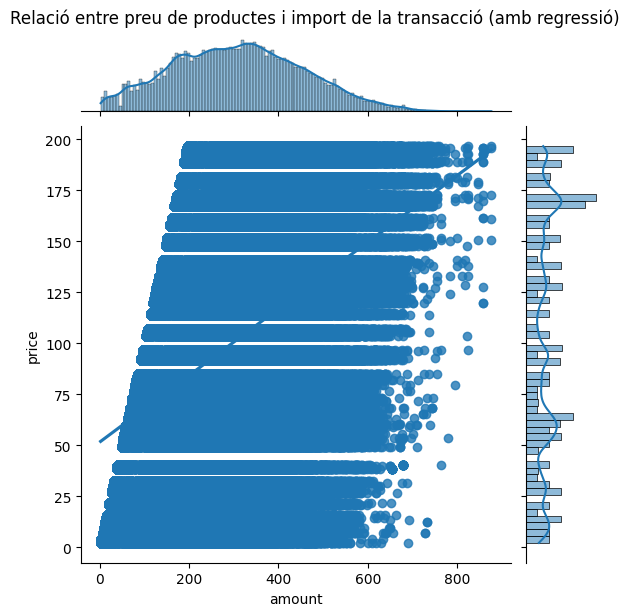

In [65]:
# NIVELL 2 - EXERCICI 1: Representa la correlació d'algunes variables i interpreta els resultats segons les teves dades.

df_trans_prod = dades["transaction_product"]

# Afegim nombre de productes per transacció
prod_count = df_trans_prod.groupby("transaction_id")["product_id"].count().reset_index()
prod_count.rename(columns={"product_id":"num_products"}, inplace=True)

# Merge
merged = df_transactions.merge(prod_count, left_on="id", right_on="transaction_id")
merged = merged.merge(df_trans_prod, left_on="id", right_on="transaction_id")
merged = merged.merge(df_products, left_on="product_id", right_on="id")

# Variables d'interès
num_vars = ["amount", "num_products", "price", "weight"]
corr = merged[num_vars].corr()

# Heatmap de correlacions
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriu de correlació entre variables")
plt.show()


# hi ha una relació positiva en quant al preu de producte i el nombre de productes comprats amb l'amount gastat.
# També hi ha correlació, encara que menys notable amb el pes del producte comprat i l'amount gastat. 


# Jointplot amb regressió lineal
sns.jointplot(data=merged, x="amount", y="price", kind="reg")
plt.suptitle("Relació entre preu de productes i import de la transacció (amb regressió)", y=1.02)
plt.show()

# Com era d’esperar, a mesura que puja el preu del producte, els imports de les transaccions també solen ser més elevats.
# Encara que hi ha correlació, la dispersió és gran, hi ha productes barats (p. ex. 10 €) que generen imports alts → es deuen a compres amb molts productes barats.
# Per altra banda, hi ha productes cars (p. ex. 200 €) en transaccions amb imports relativament baixos → pot ser perquè es compren poques unitats.

In [66]:
# NIVELL 3 - EXERCICI 1: Transfereix totes les visualitzacions del Nivell 1 a Power BI utilitzant scripts de Python.

# en PBI adjunto, sprint 11.pbix
